In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *


In [112]:
cls_file_name = "Log_model_1gram.sav"
cls = pickle.load(open(cls_file_name, "rb"))

vectorizer_file_name = "tfidf_1gram.sav"
tfidf = pickle.load(open(vectorizer_file_name, "rb"))

#coeffcients the parameter of the linear regression model
coeffcients = cls.coef_[0]

#feature_to_weight is a map between the word and its index in an array
feature_to_weight = dict()
feature_name = tfidf.get_feature_names()
for i, j in enumerate(feature_name):
    feature_to_weight[j] = i



In [113]:
Sample_correct = ["this is good .", 1]
Sample_misclassify = ["nothing is wrong .", 1]
Sample_incorrect = ["this is not good .", 0]

Sample = Sample_misclassify


In [114]:

def predictAnalysis(cls, Sample):
    wordVector = tfidf.transform([Sample[0]])
    example_sentence = tfidf.inverse_transform(wordVector)[0]
    output = ""
    prediction = cls.predict(wordVector)
    confidence = cls.predict_proba(wordVector)[0][prediction]
    output += "Prediction: %d with confidence %f. \n" % (prediction, confidence)
    output += "Predictor thinks words: "
    important_word = []
    if prediction == 1:
        for w in example_sentence:
            if cls.coef_[0][feature_to_weight[w]] > 0:
                important_word.append(w)
        for w in important_word:
            output += '(' + w +  '), '
        output += "is positive, thus it predicted Positive. \n"
    else:
        for w in example_sentence:
            if cls.coef_[0][feature_to_weight[w]] < 0:
                important_word.append(w)
        for w in important_word:
            output += '(' + w +  '), '
        output += "is negative, thus it predicted Negative. \n"
    if prediction == Sample[1]:
        output += "Fortunately, it's correct. "
    else:
        output += "Unfortunately, it's incorrect. \n"
        output += "It may be because "
        important_word = []
        if prediction == 0:
            for w in example_sentence:
                if cls.coef_[0][feature_to_weight[w]] > 0:
                    important_word.append(w) 
            for w in important_word:
                output += '(' + w +  '), '
            output += " does not have enough positive weight to make the sentence Positive "
        else:
            for w in example_sentence:
                if cls.coef_[0][feature_to_weight[w]] < 0:
                    important_word.append(w) 
            for w in important_word:
                output += '(' + w +  '), '
            output += " does not have enough negative weight to make the sentence Negative "
        output += "or we have double negation which is hard to classify."
    print(output)
    
predictAnalysis(cls,Sample)

Prediction: 0 with confidence 0.921681. 
Predictor thinks words: (wrong), (nothing), is negative, thus it predicted Negative. 
Unfortunately, it's incorrect. 
It may be because (is),  does not have enough positive weight to make the sentence Positive or we have double negation which is hard to classify.


['is' 'nothing' 'wrong']


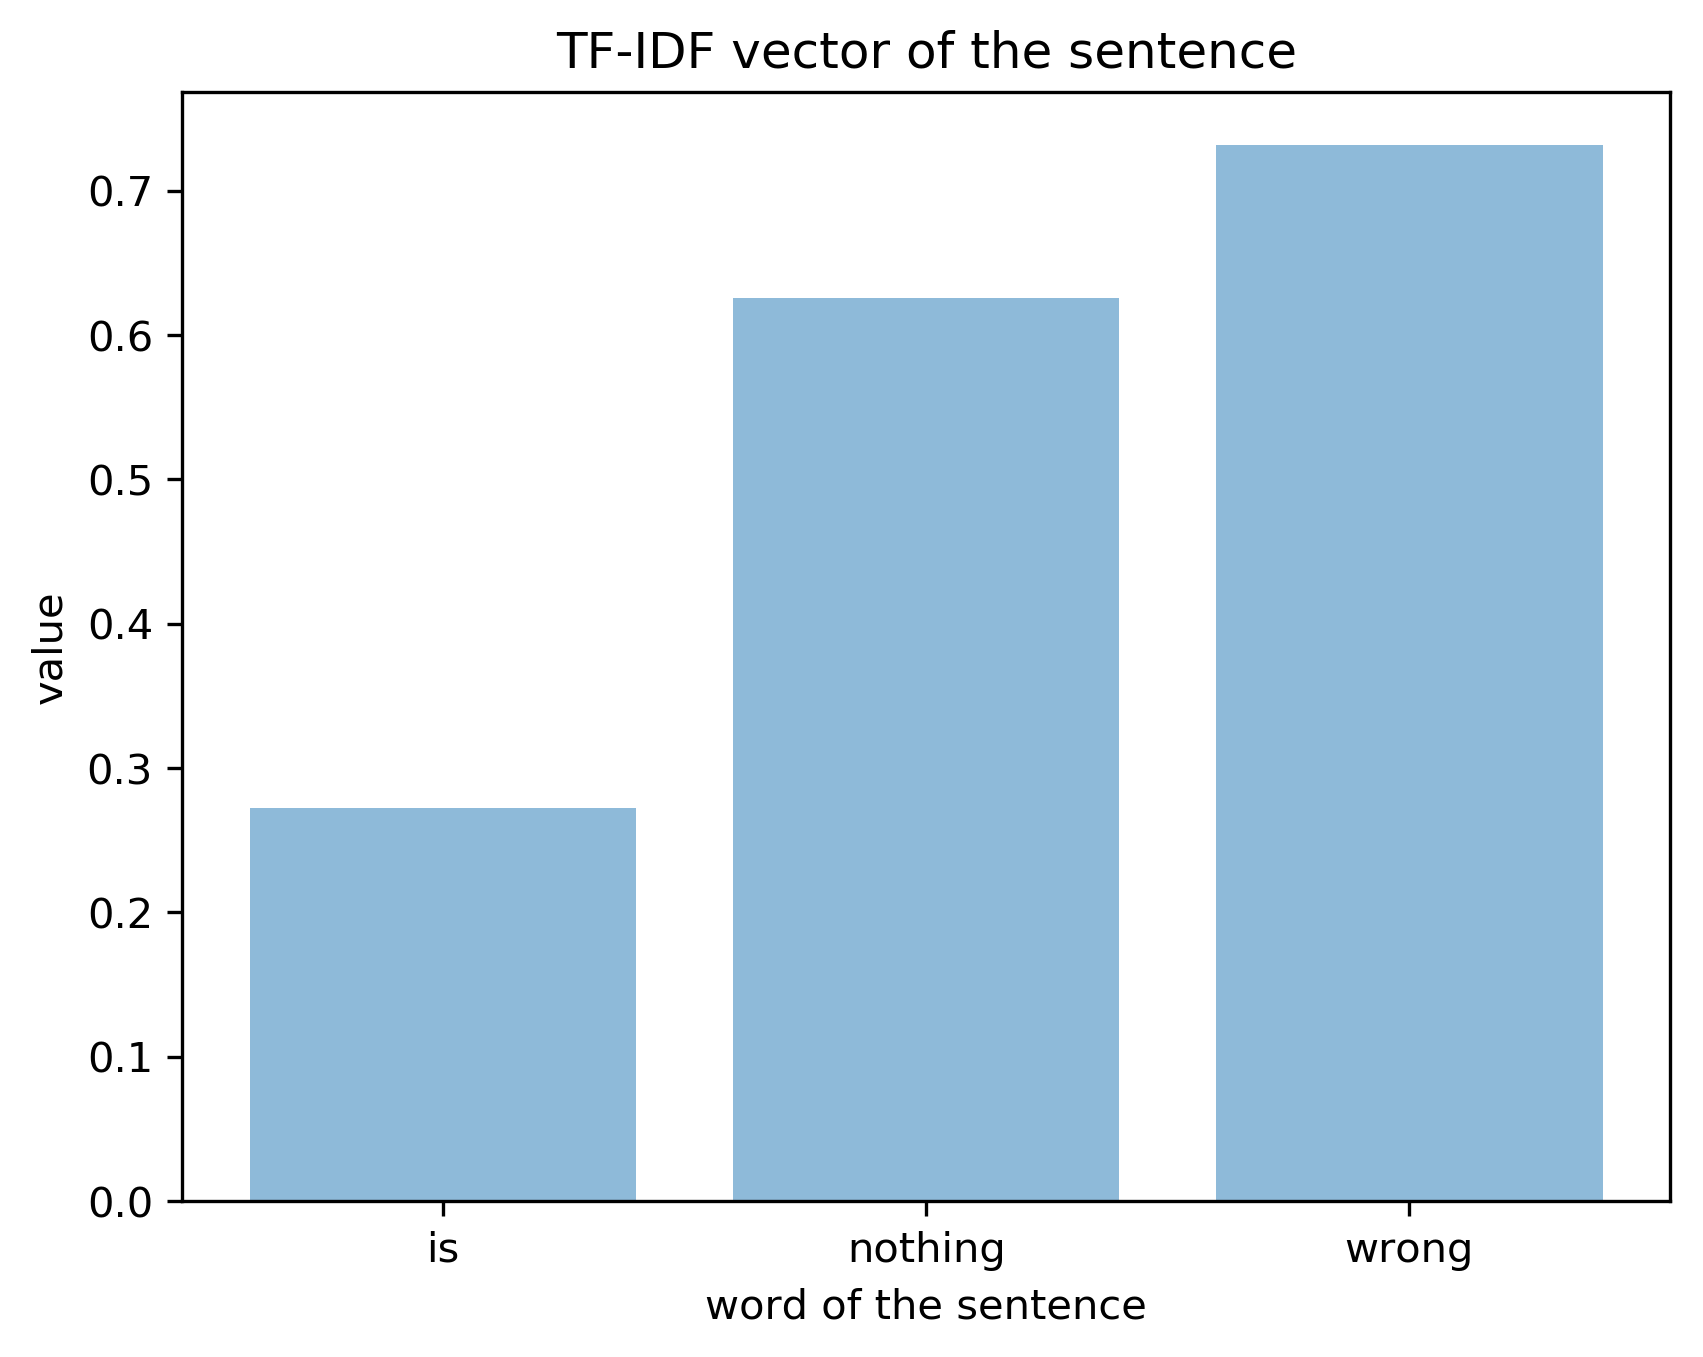

In [115]:
def drawVectorGraph(sentence,tfidf):
    wordVector = tfidf.transform([sentence])[0].toarray()
    example_sentence = tfidf.inverse_transform(wordVector)[0]
    weights = []
    print(example_sentence)
    for i, w in enumerate(example_sentence):
        index = feature_to_weight.get(w, -1)
        if index == -1:
            weights.append(0.0)
        else:
            weights.append(wordVector[0][index])

    objects = example_sentence
    y_pos = np.arange(len(objects))
    performance = weights
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('value')
    plt.xlabel('word of the sentence')
    plt.title('TF-IDF vector of the sentence')
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300
    plt.show()
    
drawVectorGraph(Sample[0],tfidf)   

['wrong' 'nothing' 'is']


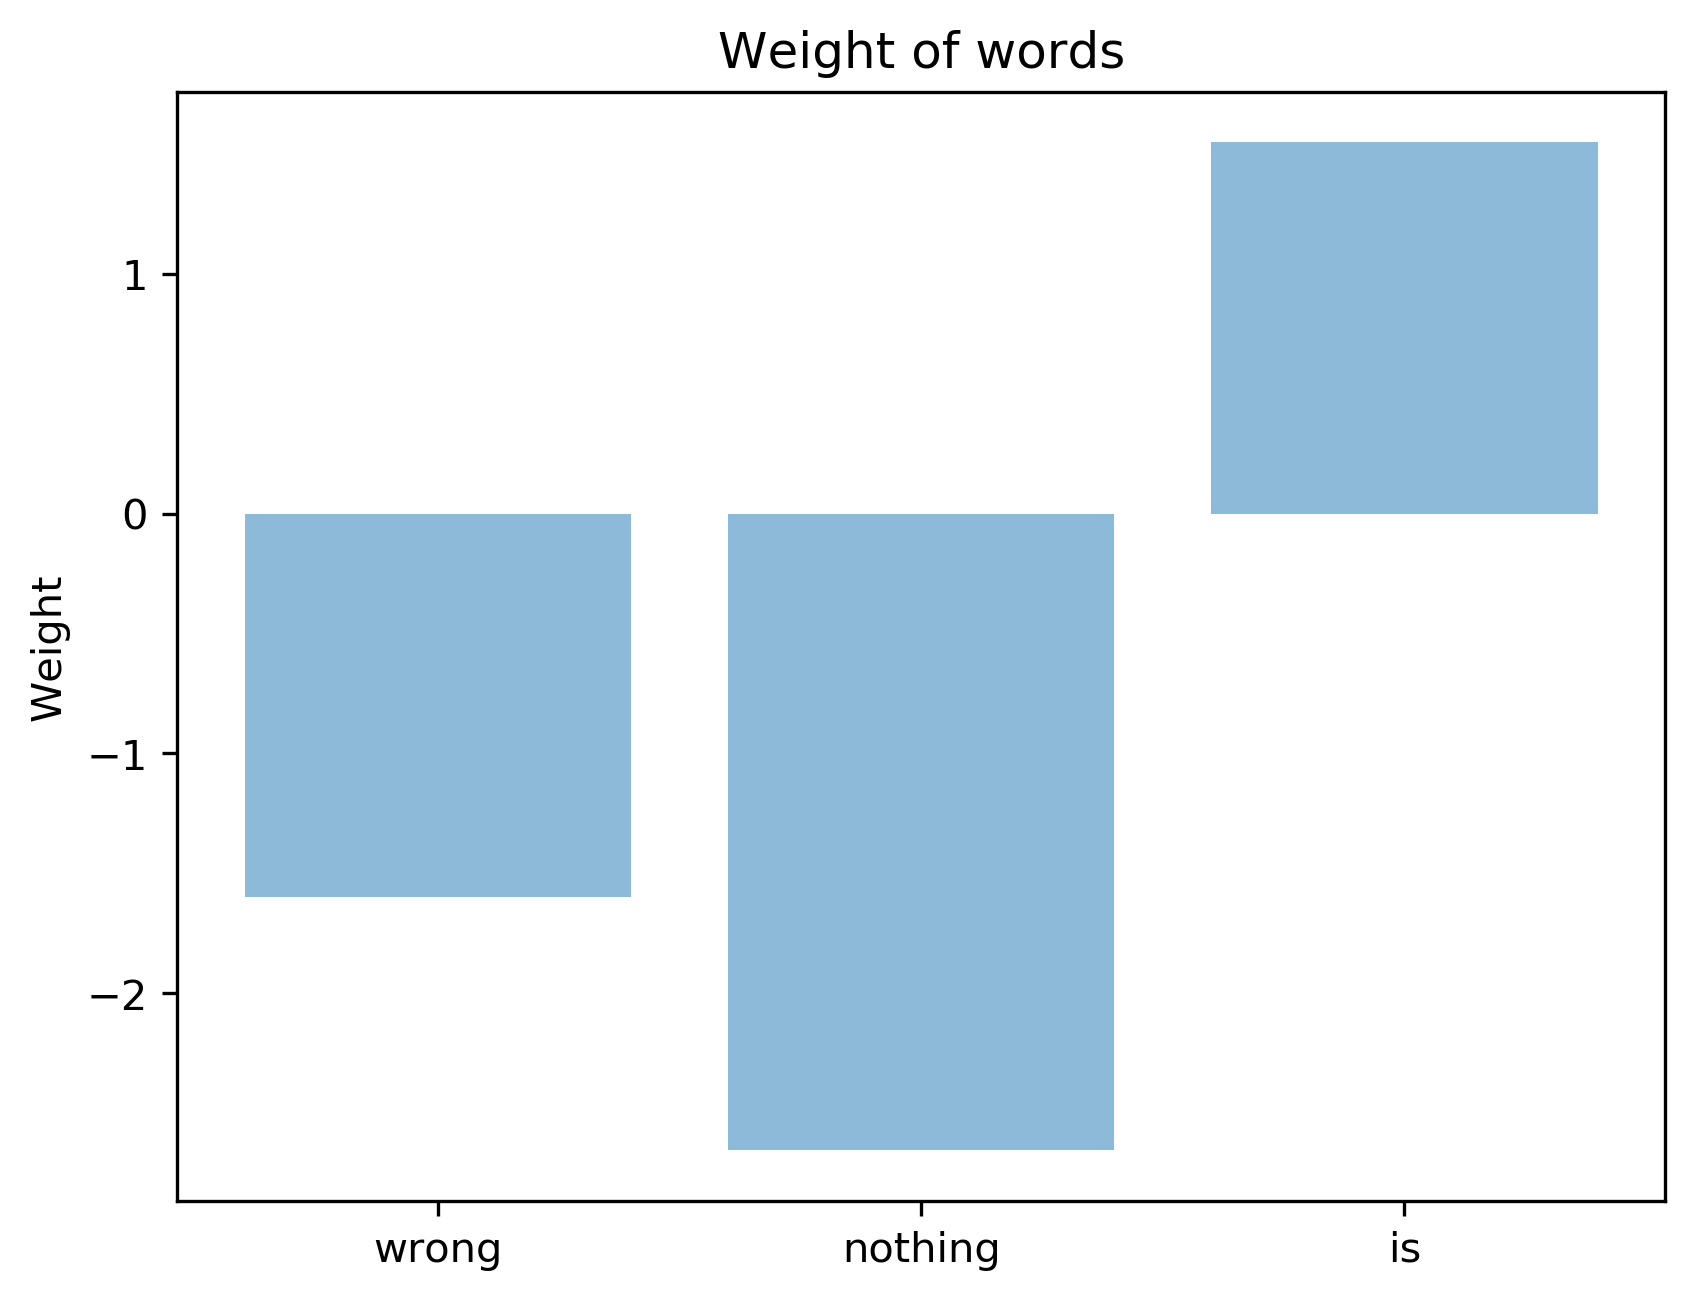

In [116]:
def drawWeightGraph(example_sentence,coeffcients):
    weights = []

    print(example_sentence)

    for i, w in enumerate(example_sentence):
        index = feature_to_weight.get(w, -1)
        if index == -1:
            weights.append(0.0)
        else:
            weights.append(coeffcients[index])

    objects = example_sentence
    y_pos = np.arange(len(objects))
    performance = weights
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Weight')
    plt.title('Weight of words')
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300
    plt.show()
  
wordVector = tfidf.transform([Sample[0]])
example_sentence = tfidf.inverse_transform(wordVector)[0]

# example_sentence = [x for x in example_sentence if len(x.split(" "))<=1]
drawWeightGraph(example_sentence,coeffcients)


In [117]:
def drawWidget(sentence,tfidf):
    temp_cls = pickle.load(open(cls_file_name, "rb"))
    test_ = tfidf.transform([sentence])
    
    a = widgets.FloatText(value =temp_cls.predict_proba(test_)[0][temp_cls.predict(test_)], description='Confidence:' )
    b = widgets.Text(value = "Positive" if temp_cls.predict(test_)== 1 else "Negative" , description='Predicted:' )

    def on_value_change(change):
        temp_cls.coef_[0][feature_to_weight[change['owner'].description]] = change['new']
        b.value = value = "Positive" if temp_cls.predict(test_)== 1 else "Negative"
        a.value = temp_cls.predict_proba(test_)[0][temp_cls.predict(test_)]

    kwarg = {}
    words = tfidf.inverse_transform(tfidf.transform([sentence]))[0]
    for w in words:
        kwarg[w] = widgets.FloatSlider(min= -10.0,max=10.0,step=0.01,value=temp_cls.coef_[0][feature_to_weight[w]], orientation='horizontal', description=w)
        kwarg[w].observe(on_value_change, names = 'value')

    output = []
    for w in kwarg:
        output.append(kwarg[w])

    display(*output)
    display(b)
    display(a)

drawWidget(Sample[0],tfidf)

FloatSlider(value=-1.5980453944920714, description='wrong', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=-2.6556492185109852, description='nothing', max=10.0, min=-10.0, step=0.01)

FloatSlider(value=1.5471685606978933, description='is', max=10.0, min=-10.0, step=0.01)

Text(value='Negative', description='Predicted:')

FloatText(value=0.9216807707365166, description='Confidence:')